In [105]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,6)
from utils import *
from filters import *
from scipy.special import ellipk as  K_fn
from scipy.special import ellipkm1 as  K_fn_2
from scipy.special import ellipj as sn_cn_dn_ph
# from scipyx import ellipj as sn_cn_dn_ph2


def sn_cn_dn_ph2(u,m):
    x = u.real
    y = u.imag

    md = 1 - m

    snx,cnx,dnx,phx = sn_cn_dn_ph(x,m)
    sny,cny,dny,phy = sn_cn_dn_ph(y,md)

    delta = cny**2 + m*(snx**2)*(sny**2)

    snz = (snx*dny + 1j*sny*cny*dnx)/delta
    cnz = (cnx*cny - 1j*snx*dnx*sny*dny)/delta
    dnz = (dnx*cny*dny - m*1j*snx*cnx*sny)/delta

    phz = np.arctan((snx*dny)/cnx)+1j*np.arctan(sny*dnx)

    return np.array([snz,cnz,dnz,phz])
    


In [106]:
delta1 = 0.15
delta2 = 0.15
fp1,fp2,fs1,fs2,f_samp = 118000,193000,113000,198000,600000

[wp1,wp2,ws1,ws2] = normalize(f_samp,[fp1,fp2,fs1,fs2])

[Op1,Op2,Os1,Os2] = to_analog([wp1,wp2,ws1,ws2])

[OLp1,OLp2,OLs1,OLs2],B,Omega_o,tr_fn = Bp_to_lp(Op1,Op2,Os1,Os2)

In [107]:
omega_p,omega_s = max(abs(OLp1),abs(OLp2)),min(abs(OLs1),abs(OLs2))

In [108]:
print(omega_p,omega_s)

1.0 1.1476878311691505


In [109]:
# parameters
d1 = 1/(1-delta1)**2 - 1
d2 = 1/delta2**2 - 1 

eps = np.sqrt(d1)
k1 = eps/np.sqrt(d2) 
k1d = np.sqrt(1 - k1**2)

k = omega_p/omega_s
kd = np.sqrt(1-k**2)

K_k = K_fn(k**2)
Kd_k1 = K_fn(k1d**2)
Kd_k = K_fn(kd**2)
K_k1 = K_fn(k1**2)

N = int(np.ceil((K_k*Kd_k1)/(Kd_k*K_k1)))

In [110]:
N

4

In [111]:
k = 0.8571 # from ellipdeg_fn MATLAB
asne  = 0.7954j # from asne fn MATLAB

L = N//2
r = N%2

In [112]:
i = np.arange(L)+1

In [113]:
u = (2*i - 1)/N

In [114]:
lol = sn_cn_dn_ph(u*K_k,k**2)
zetaa =  lol[1]/lol[2]

In [115]:
zeros = 1j/(k*zetaa)
poles = np.append(zeros,np.conjugate(zeros))

In [116]:
v_o = ((-1j)*asne)/(K_k1*N)

loleal = sn_cn_dn_ph2((u-1j*v_o)*K_k,k)

poles = 1j*(loleal[1]/loleal[2])
poles = np.append(poles,np.conjugate(poles))

In [117]:
if r == 1 : 
    pole0 = 1j*sn_cn_dn_ph2(1j*v_o*K_k,k)[0]
    poles = np.append(pole0,poles)

In [118]:
def trans_fn(x):
    A  = np.prod(-poles)/np.prod(-zeros)
    return A*np.prod(x-zeros)/np.prod(x-poles)

In [119]:
ang_freq = np.linspace(0,1.5*omega_s,1401)
response = np.vectorize(trans_fn)(ang_freq*(1j))

mag_resp = np.absolute(response)
phase = np.angle(response)

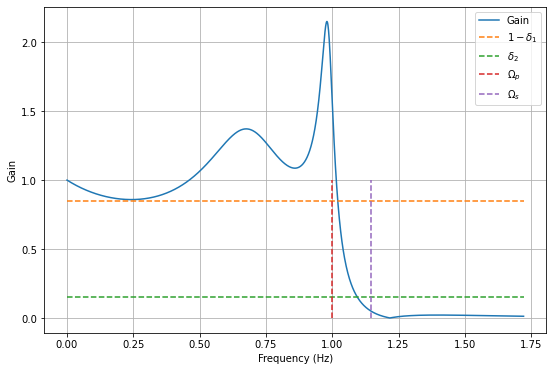

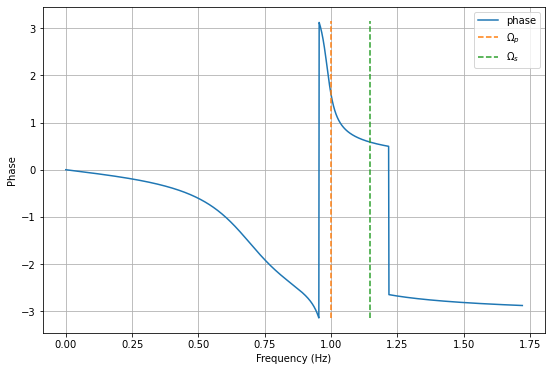

In [120]:
plt.plot(ang_freq,mag_resp,label="Gain")
plt.plot([ang_freq[0],ang_freq[-1]], [1-delta1,1-delta1],'--', label='$1-\delta_1$')
plt.plot([ang_freq[0],ang_freq[-1]], [delta2,delta2],'--', label='$\delta_2$')
plt.plot([omega_p,omega_p], [0,1],'--', label='$\Omega_p$')
plt.plot([omega_s,omega_s], [0,1],'--', label='$\Omega_s$')
# plt.plot([omega_c,omega_c], [0,1],'--', label='$\Omega_c$')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

plt.savefig('Gain_sL.pdf')

plt.show()

plt.plot(ang_freq,phase,label="phase")
plt.plot([omega_p,omega_p], [-pi,pi],'--', label='$\Omega_p$')
plt.plot([omega_s,omega_s], [-pi,pi],'--', label='$\Omega_s$')
# plt.plot([omega_c,omega_c], [-pi,pi],'--', label='$\Omega_c$')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase')
plt.grid(True)
plt.legend(loc='best')
plt.savefig('Phase_sL.pdf')
plt.show()

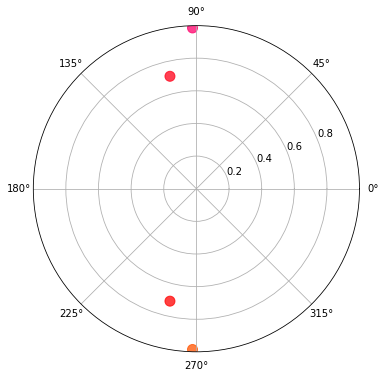

In [121]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(np.angle(poles), np.abs(poles), c=np.angle(poles), s=100, cmap='hsv', alpha=0.75)
plt.savefig('Poles_sL.pdf')

In [122]:
sl = symbols('sl') # creating the symbolic sL
Tr_fn_lp = trans_fn(sl) # passing symbol to lp transfer function 
print(latex(round_expr(simplify(expand(Tr_fn_lp)),3)))

\frac{- 0.16 sl^{2} + 0.594 i sl + 0.486}{1.0 sl^{4} + 0.372 sl^{3} + 1.488 sl^{2} + 0.339 sl + 0.486}


In [135]:
s = symbols('s')
freq_trfn = sb_tr_fn(s) # S-transformation we obtained from sb_to_lp
Tr_fn_sb = Tr_fn_lp.subs(sl,freq_trfn) # substituting the frequency transform here
print(latex(round_expr(collect(expand(simplify(Tr_fn_sb)),'s'),3)))

\frac{0.486 s^{8}}{0.486 s^{8} + 0.299 s^{7} + 3.65 s^{6} + 1.404 s^{5} + 8.355 s^{4} + 1.797 s^{3} + 5.975 s^{2} + 0.627 s + 1.304} + \frac{0.525 i s^{7}}{0.486 s^{8} + 0.299 s^{7} + 3.65 s^{6} + 1.404 s^{5} + 8.355 s^{4} + 1.797 s^{3} + 5.975 s^{2} + 0.627 s + 1.304} + \frac{2.365 s^{6}}{0.486 s^{8} + 0.299 s^{7} + 3.65 s^{6} + 1.404 s^{5} + 8.355 s^{4} + 1.797 s^{3} + 5.975 s^{2} + 0.627 s + 1.304} + \frac{2.014 i s^{5}}{0.486 s^{8} + 0.299 s^{7} + 3.65 s^{6} + 1.404 s^{5} + 8.355 s^{4} + 1.797 s^{3} + 5.975 s^{2} + 0.627 s + 1.304} + \frac{4.459 s^{4}}{0.486 s^{8} + 0.299 s^{7} + 3.65 s^{6} + 1.404 s^{5} + 8.355 s^{4} + 1.797 s^{3} + 5.975 s^{2} + 0.627 s + 1.304} + \frac{2.577 i s^{3}}{0.486 s^{8} + 0.299 s^{7} + 3.65 s^{6} + 1.404 s^{5} + 8.355 s^{4} + 1.797 s^{3} + 5.975 s^{2} + 0.627 s + 1.304} + \frac{3.872 s^{2}}{0.486 s^{8} + 0.299 s^{7} + 3.65 s^{6} + 1.404 s^{5} + 8.355 s^{4} + 1.797 s^{3} + 5.975 s^{2} + 0.627 s + 1.304} + \frac{1.099 i s}{0.486 s^{8} + 0.299 s^{7} + 3.65

In [124]:

ellip_sb = lambdify(s, Tr_fn_sb,'numpy') # returns a numpy-ready function

ang_freq = np.linspace(0,2,1401)

sb_response = ellip_sb(ang_freq*(1j))
sb_mag_resp = np.absolute(sb_response)
sb_phase = np.angle(sb_response)

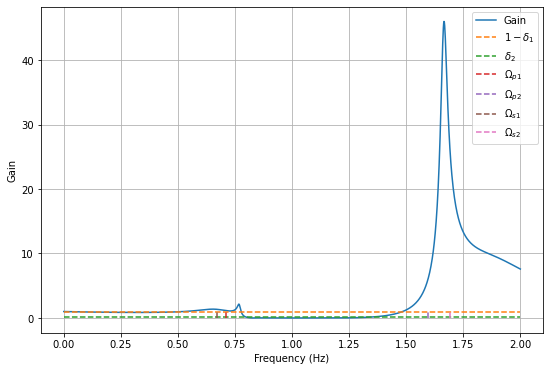

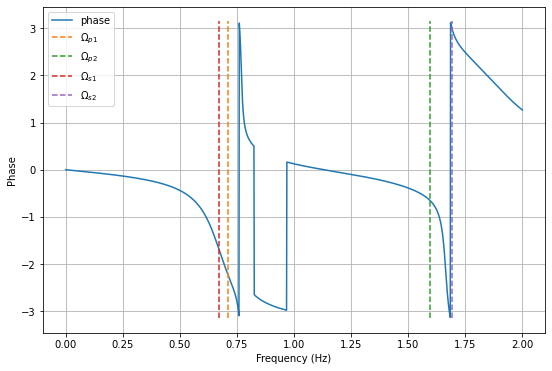

In [125]:
plt.plot(ang_freq,sb_mag_resp,label="Gain")
plt.plot([ang_freq[0],ang_freq[-1]], [1-delta1,1-delta1],'--', label='$1-\delta_1$')
plt.plot([ang_freq[0],ang_freq[-1]], [delta2,delta2],'--', label='$\delta_2$')
plt.plot([Op1,Op1], [0,1],'--', label='$\Omega_{p1}$')
plt.plot([Op2,Op2], [0,1],'--', label='$\Omega_{p2}$')
plt.plot([Os1,Os1], [0,1],'--', label='$\Omega_{s1}$')
plt.plot([Os2,Os2], [0,1],'--', label='$\Omega_{s2}$')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

plt.savefig('Gain_s.pdf')

plt.show()

plt.plot(ang_freq,sb_phase,label="phase")
plt.plot([Op1,Op1], [-pi,pi],'--', label='$\Omega_{p1}$')
plt.plot([Op2,Op2], [-pi,pi],'--', label='$\Omega_{p2}$')
plt.plot([Os1,Os1], [-pi,pi],'--', label='$\Omega_{s1}$')
plt.plot([Os2,Os2], [-pi,pi],'--', label='$\Omega_{s2}$')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase')
plt.grid(True)
plt.legend(loc='best')
plt.savefig('Phase_s.pdf')
plt.show()

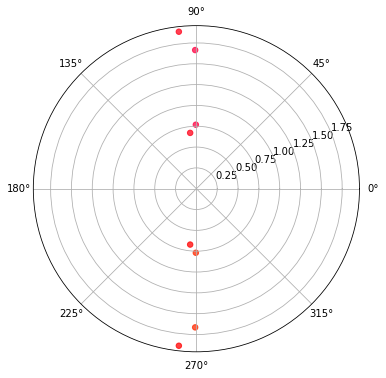

In [126]:
poles_sb = solve(1/Tr_fn_sb) # Finding Poles of System in Bandpass domain
poles_sb = np.fromiter(poles_sb,dtype=complex)
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(np.angle(poles_sb), np.abs(poles_sb), c=np.angle(poles_sb), s=30, cmap='hsv', alpha=0.75)
plt.savefig('Poles_s.pdf')

In [127]:
z = symbols('z') # Symbol for Z-domain
bilenear_trans = (z-1)/(z+1) # to transform s to z

bilenear_trans

(z - 1)/(z + 1)

In [128]:
tr_fn_z = Tr_fn_sb.subs(s,bilenear_trans) # Substitute s by bilinear transform
print(latex(round_expr(simplify(tr_fn_z).subs(I,0),3)))

\frac{12.487 z^{8} + 12.565 z^{7} + 57.235 z^{6} + 39.739 z^{5} + 89.701 z^{4} + 39.739 z^{3} + 57.235 z^{2} + 12.565 z + 12.487}{23.896 z^{8} + 18.588 z^{7} + 61.761 z^{6} + 38.694 z^{5} + 79.197 z^{4} + 34.237 z^{3} + 48.647 z^{2} + 13.089 z + 15.643}


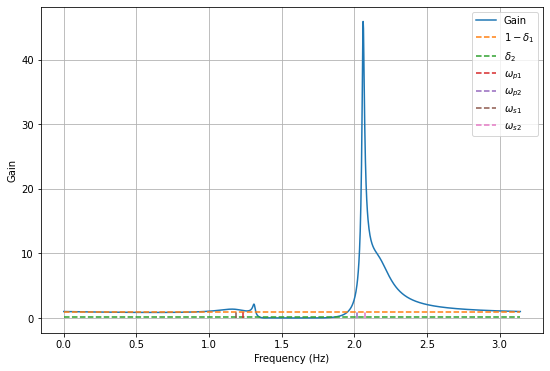

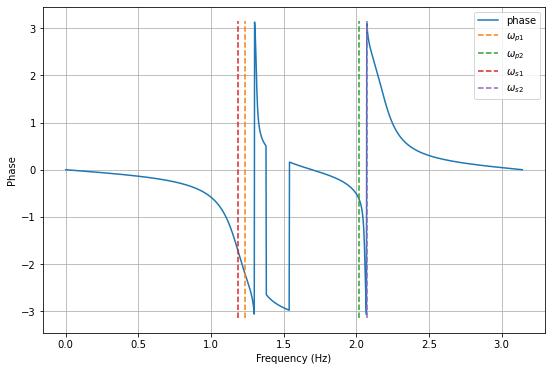

In [129]:

ellip_z = lambdify(z, tr_fn_z,'numpy') # returns a numpy-ready function

ang_freq = np.linspace(0,np.pi,1401)

z_response = ellip_z(np.exp(ang_freq*(1j)))
z_mag_resp = np.absolute(z_response)
z_phase = np.angle(z_response)

plt.plot(ang_freq,z_mag_resp,label="Gain")
plt.plot([ang_freq[0],ang_freq[-1]], [1-delta1,1-delta1],'--', label='$1-\delta_1$')
plt.plot([ang_freq[0],ang_freq[-1]], [delta2,delta2],'--', label='$\delta_2$')
plt.plot([wp1,wp1], [0,1],'--', label='$\omega_{p1}$')
plt.plot([wp2,wp2], [0,1],'--', label='$\omega_{p2}$')
plt.plot([ws1,ws1], [0,1],'--', label='$\omega_{s1}$')
plt.plot([ws2,ws2], [0,1],'--', label='$\omega_{s2}$')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

plt.savefig('Gain_z.pdf')

plt.show()

plt.plot(ang_freq,z_phase,label="phase")
plt.plot([wp1,wp1], [-pi,pi],'--', label='$\omega_{p1}$')
plt.plot([wp2,wp2], [-pi,pi],'--', label='$\omega_{p2}$')
plt.plot([ws1,ws1], [-pi,pi],'--', label='$\omega_{s1}$')
plt.plot([ws2,ws2], [-pi,pi],'--', label='$\omega_{s2}$')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase')
plt.grid(True)
plt.legend(loc='best')
plt.savefig('Phase_z.pdf')
plt.show()


In [130]:
poles_Z = solve(1/tr_fn_z) # Solve for poles of the system
poles_Z = np.fromiter(poles_Z,dtype=complex)
Zeros_Z = solve(tr_fn_z) # Solve for Zeros of the system
Zeros_Z = np.fromiter(Zeros_Z,dtype=complex)

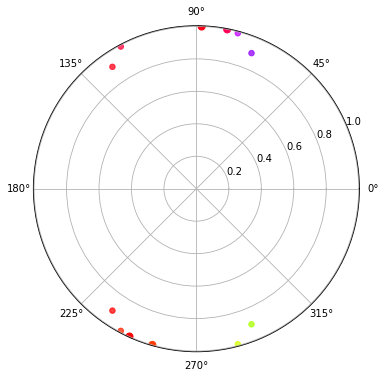

In [131]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(np.angle(poles_Z), np.abs(poles_Z), c=np.angle(poles_Z), s=30, cmap='hsv', alpha=0.75)
c = ax.scatter(np.angle(Zeros_Z), np.abs(Zeros_Z), c=np.angle(Zeros_Z), s=50, cmap='hsv', alpha=1)
plt.savefig('Poles_Zeros_Z.pdf')

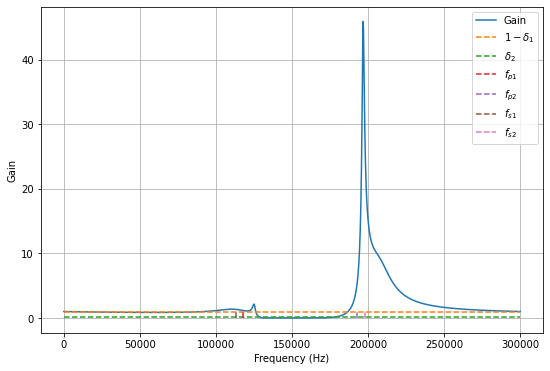

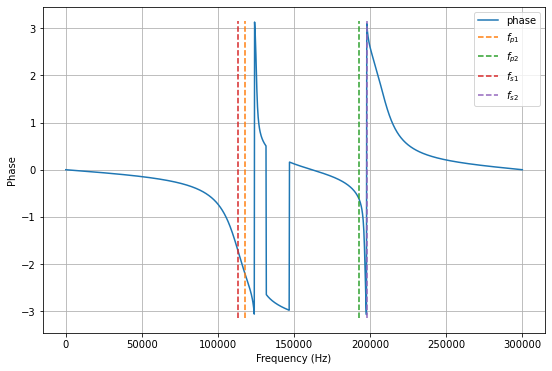

In [132]:

freq = np.linspace(0,f_samp/2,1401)

f_response = ellip_z(np.exp(normalize(f_samp,freq*(1j))))
f_mag_resp = np.absolute(f_response)
f_phase = np.angle(f_response)

plt.plot(freq,f_mag_resp,label="Gain")
plt.plot([freq[0],freq[-1]], [1-delta1,1-delta1],'--', label='$1-\delta_1$')
plt.plot([freq[0],freq[-1]], [delta2,delta2],'--', label='$\delta_2$')
plt.plot([fp1,fp1], [0,1],'--', label='$f_{p1}$')
plt.plot([fp2,fp2], [0,1],'--', label='$f_{p2}$')
plt.plot([fs1,fs1], [0,1],'--', label='$f_{s1}$')
plt.plot([fs2,fs2], [0,1],'--', label='$f_{s2}$')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

plt.savefig('Gain.pdf')

plt.show()

plt.plot(freq,z_phase,label="phase")
plt.plot([fp1,fp1], [-pi,pi],'--', label='$f_{p1}$')
plt.plot([fp2,fp2], [-pi,pi],'--', label='$f_{p2}$')
plt.plot([fs1,fs1], [-pi,pi],'--', label='$f_{s1}$')
plt.plot([fs2,fs2], [-pi,pi],'--', label='$f_{s2}$')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase')
plt.grid(True)
plt.legend(loc='best')
plt.savefig('Phase.pdf')
plt.show()
